In [34]:
"""
chapter 06
"""

# import libs

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import interp

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score 
from sklearn.model_selection import learning_curve, validation_curve

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier



In [3]:
# import dataset 
# the breast canser wisconsin dataset  

# read in the dataset from the UCI website 
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

# label encoding 
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
# malignant tumors: class 1; # benign tumors: class 0
print('label encoding:', le.transform(['M', 'B']))

# divide the dataset into a separate training dataset
# training 80%; test 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

label encoding: [1 0]


In [3]:
# combine transformers and esitimators in a pipeline 
# sklearn pipeline

# pipeline logistic regression 
# take a list of tuples as input: 
# first value: arbitrary identifier string --> to access the individual elements 
# second element: scikit-learn obj 
pipe_lr = Pipeline([('scl', StandardScaler()), # standardize the columns 
                    ('pca', PCA(n_components=2)), # compress data onto 2d subspace 
                    ('clf', LogisticRegression(random_state=1))]) # logistic regression

pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [5]:
# Stratified KFold 
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)

scores = []
for train, test in kfold:
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Class dist.: %s, Acc: %.3f' % (np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))   

Class dist.: [256 153], Acc: 0.891
Class dist.: [256 153], Acc: 0.978
Class dist.: [256 153], Acc: 0.978
Class dist.: [256 153], Acc: 0.913
Class dist.: [256 153], Acc: 0.935
Class dist.: [257 153], Acc: 0.978
Class dist.: [257 153], Acc: 0.933
Class dist.: [257 153], Acc: 0.956
Class dist.: [257 153], Acc: 0.978
Class dist.: [257 153], Acc: 0.956

CV accuracy: 0.950 +/- 0.029


In [8]:
# cross validtion score 
# note: scoring parameters: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scores = cross_val_score(estimator=pipe_lr, scoring='accuracy', X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]

CV accuracy: 0.950 +/- 0.029


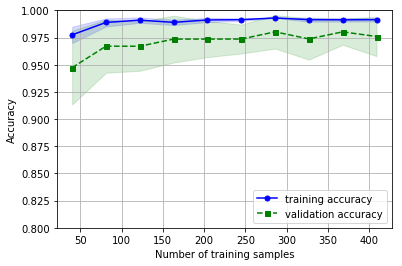

In [4]:
# ----------------- learning curve -------------------------
# pipe line learner 
pipe_lr = Pipeline([
          ('scl', StandardScaler()),  # standardize data 
          ('clf', LogisticRegression(penalty='l2', random_state=0))])  # logistic regression

# learning_curve: default use stratified k-fold cross-validation 
# calculate the average accuracies from the returned cross-validated training 
# and test scores for the different sizes of the training set
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                      X=X_train, 
                      y=y_train, 
                      train_sizes=np.linspace(0.1, 1.0, 10), # [0.1,0.2,...,0.9,1.]
                      cv=10,  # cross validation 
                      n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)  # indicate the variance of the estimate

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) # indicate the variance of the estimate

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

# performs quite well on the test dataset. 
# However, it may be slightly overfitting the training  
# data indicated by a relatively small, but visible, 
# gap between the training and cross-validation accuracy curves

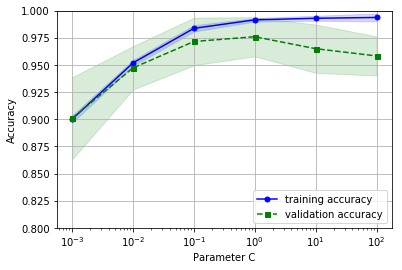

In [10]:
# ------------------ validation curve --------------------------------
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# validation_curve: stratified k-fold cross-validation by default 
# to estimate the pe rformance of the model
train_scores, test_scores = validation_curve(
               estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                # param_name='clf__C', not a random name
                # in pipe_lr --> clf=LogisticRegression   
                # in LogisticRegression, parameter C
                # validation_curve use estimator.get_params().keys()
                # another example: 'clf__intercept_scaling'
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])  # set y axix limits
plt.show() 

# slightly underfits the data when we increase the regularization strength (small values of C). 
# However, for large values of C, it means lowering the strength of regularization, 
# so the model tends to slightly overfit the data. 
# In this case, the sweet spot appears to be around C=0.1.

In [15]:
# ---------------------- grid search -----------------------
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range, 
               'clf__kernel': ['linear']},
              {'clf__C': param_range, 
               'clf__gamma': param_range,  # specific to kernel svm
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)  # n_jobs=-1, use all the cores
gs = gs.fit(X_train, y_train)


print('best score:', gs.best_score_) 
print('best parameter:', gs.best_params_)

# use the independent test dataset to estimate the performance of the best selected model
clf = gs.best_estimator_
print('best estimator:', clf)
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

best score: 0.978021978021978
best parameter: {'clf__C': 0.1, 'clf__kernel': 'linear'}
best estimator: Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])
Test accuracy: 0.965


In [16]:
# ------------- nested cross-validation -------------------
# pipe_svc 
gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid,
                  scoring='accuracy', 
                  cv=10, 
                  n_jobs=-1)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [20]:
# nested cross-validation
# decision tree 
gs = GridSearchCV(
      estimator=DecisionTreeClassifier(random_state=0),
      param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy', 
                  cv=5,
                  n_jobs=-1)

scores = cross_val_score(gs, 
                         X_train, 
                         y_train, 
                         scoring='accuracy',
                         cv=5)

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# the nested cross-validation performance of the SVM  
# model (97.8 percent) is notably better than the performance of the decision tree  
# (90.8 percent).

CV accuracy: 0.908 +/- 0.045


confusion matrix: 
 [[71  1]
 [ 2 40]]


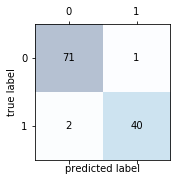

In [26]:
# ----------------------- confusion matrix --------------------

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('confusion matrix: \n', confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()        

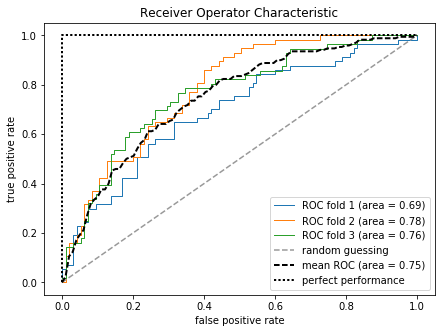

ROC AUC: 0.671
Accuracy: 0.728


In [35]:
# -------------------- ROC, AUC ------------------------

#  only uses two features from the Breast Cancer Wisconsin dataset 
X_train2 = X_train[:, [4, 14]]  


cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train2, y_train))

fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# plot the ROC curve of each iteration (cross validation)
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])    
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

# plot random gussing: diagonal  
plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

# plot mean ROC
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plot perfect performance: 
# the top-left corner of the graph with a true positive rate=1; a false positive rate=0  
plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')

# legend 
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

# calculate the ROC AUC score on the independent test dataset
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])

# yield further insights in a classifier's performance 
# with respect to imbalanced samples
# however, ROC AUC and accuracy metrics mostly agree with each other
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

In [ ]:
# make score 
pre_scorer = make_scorer(score_func=precision_score, # define score function 
                         pos_label=1,  # define positive label 
                         # whether score_func is a score fun (greater is better) 
                         # or a loss fun (less is better )
                         greater_is_better=True, 
                         average='micro')  # micro or macro
